# **Time threshold**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix.csv"

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report
import pickle

In [ ]:
df = pd.read_csv(file_path)
df = df.drop(columns=[f"time_{i}" for i in range(1,5)])
print(f"total graphs: {len(df)}")

total graphs: 226


In [ ]:
synth_df = df.loc[:145].copy()
real_df = df.loc[146:].copy()

real_train, real_test = train_test_split(real_df, test_size = 0.2, random_state=32)
synth_train, synth_test = train_test_split(synth_df, test_size = 0.3, random_state=32)
print(f"real_train: {real_train.shape}\n"
      f"real_test: {real_test.shape}\n"
      f"synth_train: {synth_train.shape}\n"
      f"synth_test: {synth_test.shape}")

real_train: (64, 24)
real_test: (16, 24)
synth_train: (102, 24)
synth_test: (44, 24)


In [ ]:
train_df = pd.concat([real_train, synth_train], ignore_index=True)
test_df = pd.concat([real_test, synth_test], ignore_index=True)

time_cols = ['time_5', 'time_6', 'time_7', 'time_8']
feature_cols = ['mxc_nodes', 'mxc_edges', 'mxc_density','mxc_max_degree', 'mxc_avg_degree', 'R', 'min_core','degeneracy', 'upper_bound', 'edge', 'sub_edge']

X_train = train_df[feature_cols]
X_test = test_df[feature_cols]

TIMEOUT_THRESHOLD = 3110.0
summary = []

for col in time_cols:
    fast = (df[col] < TIMEOUT_THRESHOLD).sum()
    slow = (df[col] >= TIMEOUT_THRESHOLD).sum()
    total = len(df)

    summary.append({
        'Time': col,
        'Fast (<threshold)': fast,
        'Slow (≥threshold)': slow,
        'Total': total,
        'Fast %': round(100 * fast / total, 2),
        'Slow %': round(100 * slow / total, 2)
    })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

  Time  Fast (<threshold)  Slow (≥threshold)  Total  Fast %  Slow %
time_5                152                 74    226   67.26   32.74
time_6                153                 73    226   67.70   32.30
time_7                152                 74    226   67.26   32.74
time_8                152                 74    226   67.26   32.74


In [ ]:
time_cols = ['time_5', 'time_6', 'time_7', 'time_8']

# For training set
train_df[[col + "_bin" for col in time_cols]] = 0  # initialize
for i, row in train_df.iterrows():
    min_col = row[time_cols].idxmin()         # column with lowest time
    train_df.at[i, min_col + "_bin"] = 1     # mark only the fastest as 1

# For test set
test_df[[col + "_bin" for col in time_cols]] = 0  # initialize
for i, row in test_df.iterrows():
    min_col = row[time_cols].idxmin()
    test_df.at[i, min_col + "_bin"] = 1

train_df.head()


,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,mxc_edges,mxc_density,mxc_max_degree,mxc_avg_degree,R,min_core,degeneracy,upper_bound,edge,sub_edge,time_5,time_6,time_7,time_8,time_5_bin,time_6_bin,time_7_bin,time_8_bin
0,email-EU_LCC_remapped,18.181868,2.444807,1.700749,32431,0.000103,623,3.354630,13.132104,128,2290,0.281742,79,35.781250,3,0,22,48,54397,28949,22.97,22.48,23.66,22.50,0,1,0,0
1,out_dimacs10-as22july06_cleaned_LCC_remapped,32.941722,2.140269,2.169744,22964,0.000184,2390,4.218429,11.514823,71,1355,0.545272,68,38.169014,3,0,25,55,48436,40439,53944.74,52938.58,53128.57,53177.74,0,1,0,0
2,soc-political-retweet_LCC_remapped,16.700123,3.468548,2.689946,18471,0.000282,786,5.203075,14.325048,193,2990,0.161377,94,30.984456,3,0,18,40,48053,36904,0.38,0.37,0.37,0.36,0,0,0,1
3,as19991108_remapped,17.540764,0.123645,2.015358,12046,0.000332,1385,3.999502,13.162327,186,370,0.021505,183,3.978495,3,2,3,5,24092,24089,0.15,0.15,0.14,0.16,0,0,1,0
4,DD_LCC_remapped,2.619664,0.000000,2.000000,14240,0.000281,13,3.998315,2.619664,14240,28468,0.000281,13,3.998315,3,2,2,3,28480,28468,0.02,0.02,0.01,0.02,0,0,1,0




*   List item
*   List item



In [ ]:
train_df.to_csv("/content/drive/MyDrive/Colab Notebooks/CSE491/train_df_bin.csv", index=False)
test_df.to_csv("/content/drive/MyDrive/Colab Notebooks/CSE491/test_df_bin.csv", index=False)

In [ ]:
y_cols = ['time_5_bin', 'time_6_bin', 'time_7_bin', 'time_8_bin',]
y_train = train_df[y_cols]
y_test = test_df[y_cols]

In [ ]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

binary_models = {}
training_results = []

for time_col in time_cols:
    # Use only the binary column for this model
    y_col = time_col + "_bin"
    y_train_col = y_train[y_col]

    model = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        min_samples_split=5,
        class_weight='balanced',
        random_state=32,
        n_jobs=-1
    )

    model.fit(X_train_scaled, y_train_col)
    binary_models[time_col] = model

    # Training accuracy
    y_train_pred = model.predict(X_train_scaled)
    train_acc = accuracy_score(y_train_col, y_train_pred)
    print(f"Train accuracy for {time_col}: {train_acc:.3f}")

    training_results.append({
        'Time': time_col,
        'Train_Samples': len(y_train_col),
        'Train_Fast': y_train_col.sum(),
        'Train_Slow': len(y_train_col) - y_train_col.sum(),
        'Train_Accuracy': f"{train_acc:.3f}"
    })

print("\nTraining Summary:")
print(pd.DataFrame(training_results).to_string(index=False))


Train accuracy for time_5: 0.946
Train accuracy for time_6: 0.982
Train accuracy for time_7: 0.976
Train accuracy for time_8: 0.970

Training Summary:
  Time  Train_Samples  Train_Fast  Train_Slow Train_Accuracy
time_5            166          37         129          0.946
time_6            166          44         122          0.982
time_7            166          34         132          0.976
time_8            166          51         115          0.970


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("\n[Testing] Winner-Take-All evaluation...")

final_y_pred = []  # binary prediction (1 = winner predicted)
final_y_true = []  # ground truth from y_test
regret_list = []

# Loop over each test instance
for i, row_features in enumerate(X_test_scaled):
    probs = {}

    # Get probability of being fast for each model
    for tc in time_cols:
        prob_fast = binary_models[tc].predict_proba(row_features.reshape(1, -1))[0][1]
        probs[tc] = prob_fast

    # Select model with highest confidence
    print(f"Probs: {probs}")
    predicted_algo = max(probs, key=probs.get)

    # Binary prediction: 1 = predicted winner
    y_pred = 1

    # True label for that predicted algorithm
    y_col = predicted_algo + "_bin"
    y_true = int(y_test.iloc[i][y_col])

    final_y_pred.append(y_pred)
    final_y_true.append(y_true)

    print(f"Sample {i}")
    print(f"  predicted_algo : {predicted_algo}")
    print(f"  y_pred         : {y_pred}")
    print(f"  y_true         : {y_true}")

# Metrics
accuracy  = accuracy_score(final_y_true, final_y_pred)
precision = precision_score(final_y_true, final_y_pred, zero_division=0)
recall    = recall_score(final_y_true, final_y_pred, zero_division=0)
f1        = f1_score(final_y_true, final_y_pred, zero_division=0)

print("\nFINAL METRICS (Winner-Take-All)")
print(f"Accuracy      : {accuracy:.3f}")
print(f"Precision     : {precision:.3f}")
print(f"Recall        : {recall:.3f}")
print(f"F1-Score      : {f1:.3f}")
print(f"Mean Regret   : {np.mean(regret_list):.2f} s")
print(f"Median Regret : {np.median(regret_list):.2f} s")

# Confusion Matrix
cm = confusion_matrix(final_y_true, final_y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(final_y_true, final_y_pred, zero_division=0))



[Testing] Winner-Take-All evaluation...
Probs: {'time_5': np.float64(0.2214684025968462), 'time_6': np.float64(0.5086632846481371), 'time_7': np.float64(0.3047980951790001), 'time_8': np.float64(0.14164463498247332)}
Sample 0
  predicted_algo : time_6
  y_pred         : 1
  y_true         : 0
Probs: {'time_5': np.float64(0.3404522744138489), 'time_6': np.float64(0.4439700635630436), 'time_7': np.float64(0.3185578350569536), 'time_8': np.float64(0.154232529827892)}
Sample 1
  predicted_algo : time_6
  y_pred         : 1
  y_true         : 0
Probs: {'time_5': np.float64(0.2129903492400336), 'time_6': np.float64(0.23634490082380125), 'time_7': np.float64(0.3964999287118198), 'time_8': np.float64(0.19244377762598505)}
Sample 2
  predicted_algo : time_7
  y_pred         : 1
  y_true         : 1
Probs: {'time_5': np.float64(0.26455619836572286), 'time_6': np.float64(0.3425615865881661), 'time_7': np.float64(0.16318029689763874), 'time_8': np.float64(0.23344865743037674)}
Sample 3
  predicte

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# **Multi-label (inverse-sum)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix.csv"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(file_path)
df.tail()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,edge,sub_edge,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8
221,as19991122_remapped,17.557157,0.169385,2.029390,12113,0.000330,1396,3.999505,18.497933,357,...,24226,24223,0.13,0.14,0.15,0.13,0.15,0.12,0.11,0.16
222,as19991204_remapped,17.758524,0.162718,2.027045,12202,0.000328,1414,3.999508,17.781652,331,...,24404,24401,0.14,0.16,0.17,0.17,0.17,0.14,0.13,0.16
223,as19991205_remapped,17.772972,0.123678,2.015368,12168,0.000329,1412,3.999507,13.237984,188,...,24336,24333,0.16,0.15,0.16,0.15,0.15,0.15,0.12,0.13
224,as19991206_remapped,17.774585,0.123389,2.015295,12226,0.000327,1417,3.999509,13.237984,188,...,24452,24449,0.16,0.16,0.16,0.16,0.14,0.13,0.14,0.15
225,as20000102_remapped,18.038514,0.161074,2.026487,12572,0.000318,1460,3.999523,17.865763,334,...,25144,25141,0.14,0.17,0.16,0.12,0.14,0.16,0.14,0.14


In [ ]:
df = df.drop(columns=['min_core']+ [f"time_{i}" for i in range(1,5)])
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,mxc_avg_degree,R,degeneracy,upper_bound,edge,sub_edge,time_5,time_6,time_7,time_8
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,29.284422,3,15,33,1097924,1094751,13.14,13.29,14.07,12.04
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,30.745596,3,16,35,1152645,1149598,10.30,9.60,12.06,11.25
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,32.077107,3,17,37,1200915,1198092,10.78,10.35,11.56,10.17
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,32.126464,3,18,40,1250377,1247617,18.04,17.96,15.72,16.85
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,34.657089,3,18,40,2600868,2595685,48.74,45.87,49.70,40.67


In [ ]:
time_cols = ["time_5", "time_6", "time_7", "time_8"]

def time_to_probs(row):
    t = row[time_cols].values
    inv = 1 / t                     # inverse times
    probs = inv / inv.sum()         # normalize to probabilities
    return pd.Series(probs, index=[f"prob_5", "prob_6", "prob_7", "prob_8"])


def convert_to_multilabel_probs(row, threshold=0.23):  #0.25
    """
    Create multi-label ground truth:
    label = 1 if probability >= threshold
    """
    probs = row[["prob_5", "prob_6", "prob_7", "prob_8"]].values
    labels = (probs >= threshold).astype(int)
    return pd.Series(labels, index=["label_5", "label_6", "label_7", "label_8"])


# ----------------------------------------------------------
# APPLY TO DATASET
# ----------------------------------------------------------

# 1. Compute probabilities
prob_df = df.apply(time_to_probs, axis=1)

# 2. Attach probabilities to main df
df = pd.concat([df, prob_df], axis=1)

# 3. Generate multi-label ground truth using a threshold
label_df = df.apply(convert_to_multilabel_probs, axis=1)
df = pd.concat([df, label_df], axis=1)

In [ ]:
# Columns with multi-label ground truth
label_cols = ["label_5", "label_6", "label_7", "label_8"]

# Check rows where all labels are zero, one
all_zero_rows = df[label_cols].sum(axis=1) == 0
# Number of rows with all labels = 0,1
num_all_zero = all_zero_rows.sum()
print(f"Number of rows with all labels = 0: {num_all_zero}")

Number of rows with all labels = 0: 0


In [ ]:
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,time_7,time_8,prob_5,prob_6,prob_7,prob_8,label_5,label_6,label_7,label_8
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,14.07,12.04,0.249129,0.246318,0.232662,0.271890,1,1,1,1
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,12.06,11.25,0.260245,0.279221,0.222266,0.238269,1,1,0,1
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,11.56,10.17,0.247890,0.258189,0.231164,0.262758,1,1,1,1
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,15.72,16.85,0.236818,0.237872,0.271768,0.253542,1,1,1,1
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,49.70,40.67,0.235756,0.250507,0.231202,0.282536,1,1,1,1


In [ ]:
file_path_2 = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_inv_multilabel.csv"
df.to_csv(file_path_2)

In [ ]:
synth_df = df.loc[:145]
real_df = df.loc[146:]

In [ ]:
# Split
real_train, real_test = train_test_split(
    real_df,
    test_size=0.2,
    random_state=32,
)

synth_train, synth_test = train_test_split(
    synth_df,
    test_size=0.3,
    random_state=32,
)

In [ ]:
print(f"real_train: {real_train.shape}\n"
      f"real_test: {real_test.shape}\n"
      f"synth_train: {synth_train.shape}\n"
      f"synth_test: {synth_test.shape}")

real_train: (64, 31)
real_test: (16, 31)
synth_train: (102, 31)
synth_test: (44, 31)


In [ ]:
train_df = pd.concat([real_train, synth_train], ignore_index = True)
test_df = pd.concat([real_test, synth_test], ignore_index=True)

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_inv_multilabel_train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_inv_multilabel_test.csv"
test_df.to_csv(test_path)
train_df.to_csv(train_path)

In [ ]:
test_df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,time_7,time_8,prob_5,prob_6,prob_7,prob_8,label_5,label_6,label_7,label_8
0,oregon1_010526_cleaned_LCC_remapped,33.093355,1.828323,2.154452,11175,0.000375,2389,4.189530,3.629509,30,...,224.83,222.80,0.247858,0.242341,0.253745,0.256057,1,1,1,1
1,bio-grid-fruitfly_LCC_remapped,10.709843,2.748395,3.629676,7164,0.000968,176,6.933277,3.780894,47,...,0.03,0.03,0.250000,0.250000,0.250000,0.250000,1,1,1,1
2,as20000102_cleaned_LCC_remapped,24.998013,1.342805,2.010811,6475,0.000600,1458,3.883243,2.985984,21,...,1.32,1.32,0.244294,0.237508,0.259099,0.259099,1,1,1,1
3,out_petster-hamster_cleaned_LCC_remapped,21.106117,6.351877,9.281859,2001,0.008045,273,16.089955,0.000000,25,...,3530.51,3695.68,0.245626,0.247367,0.259298,0.247709,1,1,1,1
4,3D_28984_Tetra_LCC_remapped,29.758904,0.431912,13.905123,28985,0.000687,3816,19.919545,30.416977,27616,...,21.42,23.14,0.263481,0.240510,0.257577,0.238431,1,1,1,1


In [ ]:
# 'std_degree','std_core','avg_core','nodes','density','max_degree','avg_degree','mxc_nodes', 'mxc_edges',
# 'mxc_density','mxc_max_degree', 'mxc_avg_degree', 'R', 'min_core',
# 'degeneracy', 'upper_bound', 'edge', 'sub_edge', 'best_label'

feature_cols = ['std_degree','std_core','avg_core','density','max_degree','avg_degree','mxc_nodes',
                'mxc_edges', 'mxc_density',
                'mxc_max_degree', 'mxc_avg_degree',
                'degeneracy', 'upper_bound']

X_train= train_df[feature_cols]
y_train = train_df[['label_5','label_6','label_7','label_8']]

X_test = test_df[feature_cols]
y_test = test_df[['label_5','label_6','label_7','label_8']]

print(f"X_train: {X_train.shape},\nX_test: {X_test.shape}")

X_train: (166, 13),
X_test: (60, 13)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model_randomForest = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=700,
        class_weight="balanced",
        n_jobs=-1,
        random_state=32
    )
)

model_randomForest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=700,
                                                       n_jobs=-1,
                                                       random_state=32))

In [ ]:
# prob_pred = model_randomForest.predict_proba(X_test)

In [ ]:
prob_pred = model_randomForest.predict_proba(X_test)
prob_pred

[array([[0.07      , 0.93      ],
        [0.22857143, 0.77142857],
        [0.08428571, 0.91571429],
        [0.05      , 0.95      ],
        [0.04857143, 0.95142857],
        [0.02857143, 0.97142857],
        [0.        , 1.        ],
        [0.01571429, 0.98428571],
        [0.03714286, 0.96285714],
        [0.08285714, 0.91714286],
        [0.16857143, 0.83142857],
        [0.00714286, 0.99285714],
        [0.03      , 0.97      ],
        [0.06285714, 0.93714286],
        [0.06      , 0.94      ],
        [0.05285714, 0.94714286],
        [0.        , 1.        ],
        [0.01571429, 0.98428571],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.12428571, 0.87571429],
        [0.00142857, 0.99857143],
        [0.        , 1.        ],
        [0.00142857, 0.99857143],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        [0.   

In [ ]:
label_pred = (np.array([p[:,1] for p in prob_pred]).T > 0.9).astype(int)
label_pred

array([[1, 1, 0, 1],
       [0, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 1],
       [0, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1,

In [ ]:
# label_probs=[]
# for p in prob_pred:
#   label_probs.append(p[:,1])

# label_probs

In [ ]:
# label_probs = np.array([p[:,1] for p in prob_pred]).T
# label_probs

In [ ]:
# label_pred = (label_probs > 0.1).astype(int)
# label_pred

In [ ]:
from sklearn.metrics import f1_score, hamming_loss, accuracy_score, precision_score,recall_score


print("Exact match accuracy:", accuracy_score(y_test, label_pred))
print("Precision-micro:", precision_score(y_test, label_pred, average="micro"))
print("Recall-micro:", recall_score(y_test, label_pred, average="micro"))
print("F1-micro :", f1_score(y_test, label_pred, average="micro"))
print("F1-macro :", f1_score(y_test, label_pred, average="macro"))
print("Hamming Loss:", hamming_loss(y_test, label_pred))

Exact match accuracy: 0.7666666666666667
Precision-micro: 0.9688888888888889
Recall-micro: 0.9478260869565217
F1-micro : 0.9582417582417583
F1-macro : 0.958033485688353
Hamming Loss: 0.07916666666666666


# **Custom Evaluation Function**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## InvSum

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix.csv"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv(file_path)
df.tail()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,edge,sub_edge,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8
221,as19991122_remapped,17.557157,0.169385,2.029390,12113,0.000330,1396,3.999505,18.497933,357,...,24226,24223,0.13,0.14,0.15,0.13,0.15,0.12,0.11,0.16
222,as19991204_remapped,17.758524,0.162718,2.027045,12202,0.000328,1414,3.999508,17.781652,331,...,24404,24401,0.14,0.16,0.17,0.17,0.17,0.14,0.13,0.16
223,as19991205_remapped,17.772972,0.123678,2.015368,12168,0.000329,1412,3.999507,13.237984,188,...,24336,24333,0.16,0.15,0.16,0.15,0.15,0.15,0.12,0.13
224,as19991206_remapped,17.774585,0.123389,2.015295,12226,0.000327,1417,3.999509,13.237984,188,...,24452,24449,0.16,0.16,0.16,0.16,0.14,0.13,0.14,0.15
225,as20000102_remapped,18.038514,0.161074,2.026487,12572,0.000318,1460,3.999523,17.865763,334,...,25144,25141,0.14,0.17,0.16,0.12,0.14,0.16,0.14,0.14


In [ ]:
df = df.drop(columns=['min_core']+ [f"time_{i}" for i in range(1,5)])
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,mxc_avg_degree,R,degeneracy,upper_bound,edge,sub_edge,time_5,time_6,time_7,time_8
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,29.284422,3,15,33,1097924,1094751,13.14,13.29,14.07,12.04
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,30.745596,3,16,35,1152645,1149598,10.30,9.60,12.06,11.25
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,32.077107,3,17,37,1200915,1198092,10.78,10.35,11.56,10.17
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,32.126464,3,18,40,1250377,1247617,18.04,17.96,15.72,16.85
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,34.657089,3,18,40,2600868,2595685,48.74,45.87,49.70,40.67


In [ ]:
time_cols = ["time_5", "time_6", "time_7", "time_8"]

def time_to_probs(row):
    t = row[time_cols].values
    inv = 1 / t                     # inverse times
    probs = inv / inv.sum()         # normalize to probabilities
    return pd.Series(probs, index=[f"prob_5", "prob_6", "prob_7", "prob_8"])


def convert_to_multilabel_probs(row, threshold=0.23):  #0.25
    """
    Create multi-label ground truth:
    label = 1 if probability >= threshold
    """
    probs = row[["prob_5", "prob_6", "prob_7", "prob_8"]].values
    labels = (probs >= threshold).astype(int)
    return pd.Series(labels, index=["label_5", "label_6", "label_7", "label_8"])


# ----------------------------------------------------------
# APPLY TO DATASET
# ----------------------------------------------------------

# 1. Compute probabilities
prob_df = df.apply(time_to_probs, axis=1)

# 2. Attach probabilities to main df
df = pd.concat([df, prob_df], axis=1)

# 3. Generate multi-label ground truth using a threshold
label_df = df.apply(convert_to_multilabel_probs, axis=1)
df = pd.concat([df, label_df], axis=1)

In [ ]:
# Columns with multi-label ground truth
label_cols = ["label_5", "label_6", "label_7", "label_8"]

# Check rows where all labels are zero, one
all_zero_rows = df[label_cols].sum(axis=1) == 0
# Number of rows with all labels = 0,1
num_all_zero = all_zero_rows.sum()
print(f"Number of rows with all labels = 0: {num_all_zero}")

Number of rows with all labels = 0: 0


In [ ]:
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,time_7,time_8,prob_5,prob_6,prob_7,prob_8,label_5,label_6,label_7,label_8
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,14.07,12.04,0.249129,0.246318,0.232662,0.271890,1,1,1,1
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,12.06,11.25,0.260245,0.279221,0.222266,0.238269,1,1,0,1
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,11.56,10.17,0.247890,0.258189,0.231164,0.262758,1,1,1,1
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,15.72,16.85,0.236818,0.237872,0.271768,0.253542,1,1,1,1
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,49.70,40.67,0.235756,0.250507,0.231202,0.282536,1,1,1,1


In [ ]:
file_path_2 = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_inv_multilabel.csv"
df.to_csv(file_path_2)

In [ ]:
synth_df = df.loc[:145]
real_df = df.loc[146:]

In [ ]:
# Split
real_train, real_test = train_test_split(
    real_df,
    test_size=0.2,
    random_state=32,
)

synth_train, synth_test = train_test_split(
    synth_df,
    test_size=0.3,
    random_state=32,
)

In [ ]:
print(f"real_train: {real_train.shape}\n"
      f"real_test: {real_test.shape}\n"
      f"synth_train: {synth_train.shape}\n"
      f"synth_test: {synth_test.shape}")

real_train: (64, 31)
real_test: (16, 31)
synth_train: (102, 31)
synth_test: (44, 31)


In [ ]:
train_df = pd.concat([real_train, synth_train], ignore_index = True)
test_df = pd.concat([real_test, synth_test], ignore_index=True)

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_inv_multilabel_train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_inv_multilabel_test.csv"
test_df.to_csv(test_path)
train_df.to_csv(train_path)

In [ ]:
test_df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,time_7,time_8,prob_5,prob_6,prob_7,prob_8,label_5,label_6,label_7,label_8
0,oregon1_010526_cleaned_LCC_remapped,33.093355,1.828323,2.154452,11175,0.000375,2389,4.189530,3.629509,30,...,224.83,222.80,0.247858,0.242341,0.253745,0.256057,1,1,1,1
1,bio-grid-fruitfly_LCC_remapped,10.709843,2.748395,3.629676,7164,0.000968,176,6.933277,3.780894,47,...,0.03,0.03,0.250000,0.250000,0.250000,0.250000,1,1,1,1
2,as20000102_cleaned_LCC_remapped,24.998013,1.342805,2.010811,6475,0.000600,1458,3.883243,2.985984,21,...,1.32,1.32,0.244294,0.237508,0.259099,0.259099,1,1,1,1
3,out_petster-hamster_cleaned_LCC_remapped,21.106117,6.351877,9.281859,2001,0.008045,273,16.089955,0.000000,25,...,3530.51,3695.68,0.245626,0.247367,0.259298,0.247709,1,1,1,1
4,3D_28984_Tetra_LCC_remapped,29.758904,0.431912,13.905123,28985,0.000687,3816,19.919545,30.416977,27616,...,21.42,23.14,0.263481,0.240510,0.257577,0.238431,1,1,1,1


In [ ]:
# 'std_degree','std_core','avg_core','nodes','density','max_degree','avg_degree','mxc_nodes', 'mxc_edges',
# 'mxc_density','mxc_max_degree', 'mxc_avg_degree', 'R', 'min_core',
# 'degeneracy', 'upper_bound', 'edge', 'sub_edge', 'best_label'

feature_cols = ['std_degree','std_core','avg_core','density','max_degree','avg_degree','mxc_nodes',
                'mxc_edges', 'mxc_density',
                'mxc_max_degree', 'mxc_avg_degree',
                'degeneracy', 'upper_bound']

X_train= train_df[feature_cols]
y_train = train_df[['label_5','label_6','label_7','label_8']]

X_test = test_df[feature_cols]
y_test = test_df[['label_5','label_6','label_7','label_8']]

print(f"X_train: {X_train.shape},\nX_test: {X_test.shape}")

X_train: (166, 13),
X_test: (60, 13)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model_randomForest = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=700,
        class_weight="balanced",
        n_jobs=-1,
        random_state=32
    )
)

model_randomForest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=700,
                                                       n_jobs=-1,
                                                       random_state=32))

In [ ]:
model_predict = model_randomForest.predict(X_test)

In [ ]:
model_predict = np.array(model_predict)

In [ ]:
model_predict.shape

(60, 4)

In [ ]:
y_test

,label_5,label_6,label_7,label_8
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
5,1,0,0,1
6,1,1,1,1
7,1,1,1,1
8,1,1,1,1
9,1,1,1,0


In [ ]:
y_test.shape

(60, 4)

In [ ]:
correct = 0
total = len(y_test)

for i in range(total):
  for j in range(4):
    if y_test.iloc[i,j] == 1 and  model_predict[i,j] ==1:
      correct += 1
      break;

print(correct/total)

1.0


In [ ]:
total

60

In [ ]:
correct

60

## Divided-by-min

In [5]:
file_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix.csv"

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv(file_path)
df.tail()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,edge,sub_edge,time_1,time_2,time_3,time_4,time_5,time_6,time_7,time_8
221,as19991122_remapped,17.557157,0.169385,2.029390,12113,0.000330,1396,3.999505,18.497933,357,...,24226,24223,0.13,0.14,0.15,0.13,0.15,0.12,0.11,0.16
222,as19991204_remapped,17.758524,0.162718,2.027045,12202,0.000328,1414,3.999508,17.781652,331,...,24404,24401,0.14,0.16,0.17,0.17,0.17,0.14,0.13,0.16
223,as19991205_remapped,17.772972,0.123678,2.015368,12168,0.000329,1412,3.999507,13.237984,188,...,24336,24333,0.16,0.15,0.16,0.15,0.15,0.15,0.12,0.13
224,as19991206_remapped,17.774585,0.123389,2.015295,12226,0.000327,1417,3.999509,13.237984,188,...,24452,24449,0.16,0.16,0.16,0.16,0.14,0.13,0.14,0.15
225,as20000102_remapped,18.038514,0.161074,2.026487,12572,0.000318,1460,3.999523,17.865763,334,...,25144,25141,0.14,0.17,0.16,0.12,0.14,0.16,0.14,0.14


In [8]:
df = df.drop(columns=['min_core']+ [f"time_{i}" for i in range(1,5)])
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,mxc_avg_degree,R,degeneracy,upper_bound,edge,sub_edge,time_5,time_6,time_7,time_8
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,29.284422,3,15,33,1097924,1094751,13.14,13.29,14.07,12.04
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,30.745596,3,16,35,1152645,1149598,10.30,9.60,12.06,11.25
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,32.077107,3,17,37,1200915,1198092,10.78,10.35,11.56,10.17
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,32.126464,3,18,40,1250377,1247617,18.04,17.96,15.72,16.85
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,34.657089,3,18,40,2600868,2595685,48.74,45.87,49.70,40.67


In [9]:
time_cols = ["time_5", "time_6", "time_7", "time_8"]

def dvidied_by_min(row):
  t = row[time_cols].values.astype(float)
  min_t = t.min()
  ratios = t/min_t
  diffs = ratios-1

  positive_diffs = diffs[diffs>0]

  if(len(positive_diffs)==0):
    closest_diff=0.0
    farhtest_diff=0.0

  else:
    closest_diff = positive_diffs.min()
    farhtest_diff = positive_diffs.max()

  return pd.Series(
      [
          ratios[0],ratios[1],ratios[2],ratios[3],closest_diff,farhtest_diff
      ],
      index=[
          "ratio_5","ratio_6","ratio_7","ratio_8","closest_to_1_diff","farhtest_from_1_diff"
      ]
  )

ratio_df = df.apply(dvidied_by_min, axis=1)
df = pd.concat([df, ratio_df], axis=1)

In [ ]:
# df.to_csv("/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_divided_by_min.csv")

In [10]:
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,time_5,time_6,time_7,time_8,ratio_5,ratio_6,ratio_7,ratio_8,closest_to_1_diff,farhtest_from_1_diff
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,13.14,13.29,14.07,12.04,1.091362,1.103821,1.168605,1.000000,0.091362,0.168605
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,10.30,9.60,12.06,11.25,1.072917,1.000000,1.256250,1.171875,0.072917,0.256250
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,10.78,10.35,11.56,10.17,1.059980,1.017699,1.136676,1.000000,0.017699,0.136676
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,18.04,17.96,15.72,16.85,1.147583,1.142494,1.000000,1.071883,0.071883,0.147583
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,48.74,45.87,49.70,40.67,1.198426,1.127858,1.222031,1.000000,0.127858,0.222031


In [11]:
threshold_diff = df["closest_to_1_diff"].mean()
threshold_diff

np.float64(0.055502844909493726)

In [12]:
def convert_to_multilabel(row,threshold_diff):
  ratios = row[["ratio_5","ratio_6","ratio_7","ratio_8"]].values
  labels = (ratios <= 1+threshold_diff).astype(int)
  return pd.Series(labels, index=["label_5", "label_6", "label_7", "label_8"])

label_df = df.apply(convert_to_multilabel,axis=1,threshold_diff=threshold_diff)
df = pd.concat([df, label_df], axis=1)

In [13]:
df.head()

,grh_name(synthetic),std_degree,std_core,avg_core,nodes,density,max_degree,avg_degree,mxc_std_degree,mxc_nodes,...,ratio_5,ratio_6,ratio_7,ratio_8,closest_to_1_diff,farhtest_from_1_diff,label_5,label_6,label_7,label_8
0,scale_free_graph_m_21,35.627469,4.481167,11.176208,100001,0.000220,2064,21.95848,36.313664,38914,...,1.091362,1.103821,1.168605,1.000000,0.091362,0.168605,0,0,0,1
1,scale_free_graph_m_22,36.569533,4.760552,11.812692,100001,0.000231,2294,23.05290,36.793856,34571,...,1.072917,1.000000,1.256250,1.171875,0.072917,0.256250,0,1,0,0
2,scale_free_graph_m_23,37.870138,4.971670,12.317157,100001,0.000240,1869,24.01830,36.440907,21710,...,1.059980,1.017699,1.136676,1.000000,0.017699,0.136676,0,1,0,1
3,scale_free_graph_m_24,40.186277,5.078082,12.710503,100001,0.000250,2929,25.00754,21.032882,427,...,1.147583,1.142494,1.000000,1.071883,0.071883,0.147583,0,0,1,0
4,scale_free_graph_m_25_2nd_time,42.637274,5.363944,13.305678,200001,0.000130,3407,26.00868,43.207664,67449,...,1.198426,1.127858,1.222031,1.000000,0.127858,0.222031,0,0,0,1


In [14]:
df.to_csv("/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_divided_by_min.csv")

In [15]:
synth_df = df.loc[:145]
real_df = df.loc[146:]

In [16]:
# Split
real_train, real_test = train_test_split(
    real_df,
    test_size=0.2,
    random_state=32,
)

synth_train, synth_test = train_test_split(
    synth_df,
    test_size=0.3,
    random_state=32,
)

In [17]:
train_df = pd.concat([real_train, synth_train], ignore_index = True)
test_df = pd.concat([real_test, synth_test], ignore_index=True)

In [18]:
train_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_divided_by_min_train.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/CSE491/Final_feature_matrix_divided_by_min_test.csv"
test_df.to_csv(test_path)
train_df.to_csv(train_path)

In [64]:
# 'std_degree','std_core','avg_core','nodes','density','max_degree','avg_degree','mxc_nodes', 'mxc_edges',
# 'mxc_density','mxc_max_degree', 'mxc_avg_degree', 'R', 'min_core',
# 'degeneracy', 'upper_bound', 'edge', 'sub_edge', 'best_label'

feature_cols = ['std_degree','std_core','avg_core','nodes','density','max_degree','avg_degree','mxc_nodes', 'mxc_edges',
'mxc_density','mxc_max_degree', 'mxc_avg_degree', 'R',
'degeneracy', 'upper_bound', 'edge', 'sub_edge']

X_train= train_df[feature_cols]
y_train = train_df[['label_5','label_6','label_7','label_8']]

X_test = test_df[feature_cols]
y_test = test_df[['label_5','label_6','label_7','label_8']]

print(f"X_train: {X_train.shape},\nX_test: {X_test.shape}")

X_train: (166, 17),
X_test: (60, 17)


In [ ]:
# 'std_degree','std_core','avg_core','density','max_degree','avg_degree','mxc_nodes',
#                 'mxc_edges', 'mxc_density',
#                 'mxc_max_degree', 'mxc_avg_degree',
#                 'degeneracy', 'upper_bound'

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model_randomForest = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=700,
        class_weight="balanced",
        n_jobs=-1,
        random_state=32
    )
)

model_randomForest.fit(X_train, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=700,
                                                       n_jobs=-1,
                                                       random_state=32))

In [66]:
model_predict = model_randomForest.predict(X_test)

In [67]:
model_predict = np.array(model_predict)

In [68]:
model_predict

array([[0, 1, 1, 1],
       [0, 0, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 0, 1, 0],
       [0, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 0, 1, 1],
       [1, 0, 0, 0],
       [0, 1, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 1],
       [1, 1, 0, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1,

In [69]:
correct = 0
total = len(y_test)

for i in range(total):
  for j in range(4):
    if y_test.iloc[i,j] == 1 and model_predict[i,j] == 1:
      correct += 1
      break;

print(correct/total)

0.9


In [70]:
correct

54

# Feature Selecteion (Filter method- ANOVA Test)

In [72]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

labels = ['label_5', 'label_6', 'label_7', 'label_8']
k = 6

results = {}

for lbl in labels:
    selector = SelectKBest(score_func=f_classif, k=k)
    selector.fit(X_train, y_train[lbl])

    selected_features = X_train.columns[selector.get_support()].tolist()
    results[lbl] = selected_features

df_features = pd.DataFrame(dict(
    [(k, pd.Series(v)) for k, v in results.items()]
))

df_features

/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [12] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/

,label_5,label_6,label_7,label_8
0,avg_core,avg_degree,std_core,avg_degree
1,avg_degree,mxc_avg_degree,density,mxc_avg_degree
2,mxc_avg_degree,degeneracy,avg_degree,degeneracy
3,degeneracy,upper_bound,mxc_avg_degree,upper_bound
4,upper_bound,edge,degeneracy,edge
5,edge,sub_edge,upper_bound,sub_edge


In [73]:
X_train_sel = X_train[selected_features]
X_test_sel = X_test[selected_features]

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model_randomForest = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=700,
        class_weight="balanced",
        n_jobs=-1,
        random_state=32
    )
)

model_randomForest.fit(X_train_sel, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=700,
                                                       n_jobs=-1,
                                                       random_state=32))

In [75]:
model_predict = model_randomForest.predict(X_test_sel)

In [76]:
model_predict = np.array(model_predict)

In [77]:
model_predict

array([[0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 1],
       [0, 1, 1, 1],
       [1, 1, 0, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 0, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1,

In [78]:
correct = 0
total = len(y_test)

for i in range(total):
  for j in range(4):
    if y_test.iloc[i,j] == 1 and model_predict[i,j] == 1:
      correct += 1
      break;

print(correct/total)

0.9333333333333333


In [105]:
correct

56

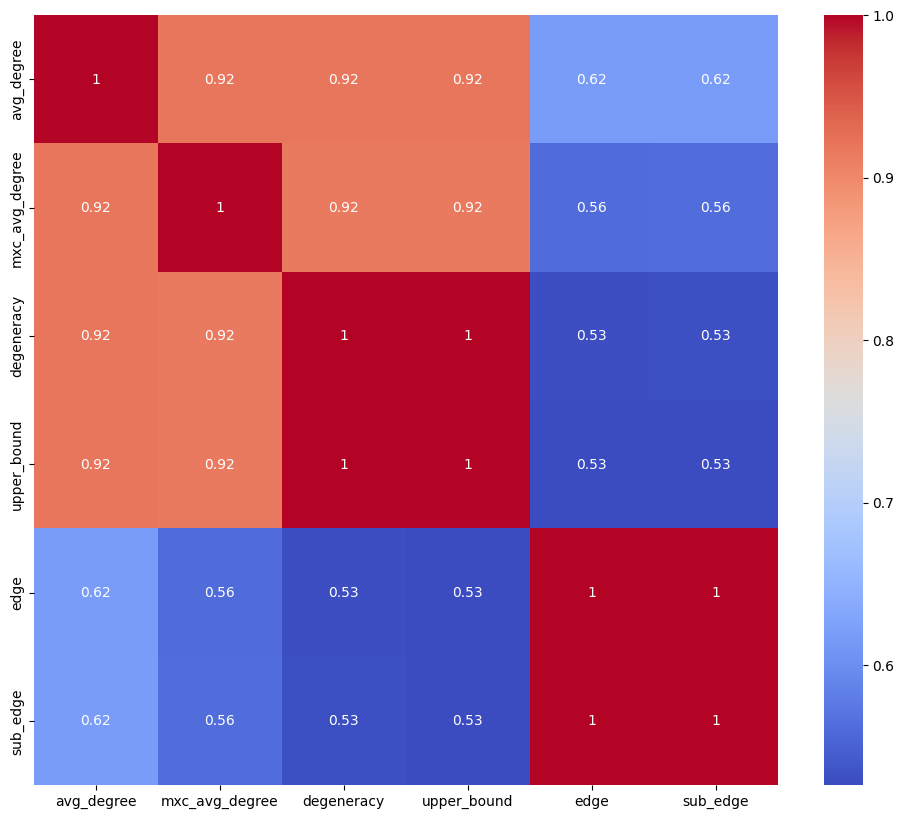

In [79]:
import seaborn as sns
corr_matrix = X_train_sel.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# Fisher's Score

In [94]:
def fisher_score(X, y):
    scores = []

    for col in X.columns:
        x = X[col]

        x1 = x[y == 1]
        x0 = x[y == 0]

        mu1, mu0 = x1.mean(), x0.mean()
        var1, var0 = x1.var(), x0.var()

        score = (mu1 - mu0) ** 2 / (var1 + var0 + 1e-8)
        scores.append(score)

    return pd.Series(scores, index=X.columns)

In [95]:
labels = ['label_5', 'label_6', 'label_7', 'label_8']
k = 6

fisher_results = {}

for lbl in labels:
    scores = fisher_score(X_train, y_train[lbl])
    top_features = scores.sort_values(ascending=False).head(k).index.tolist()
    fisher_results[lbl] = top_features

In [96]:
fisher_df = pd.DataFrame(dict(
    [(k, pd.Series(v)) for k, v in fisher_results.items()]
))

fisher_df

,label_5,label_6,label_7,label_8
0,upper_bound,mxc_avg_degree,upper_bound,mxc_avg_degree
1,degeneracy,upper_bound,degeneracy,edge
2,mxc_avg_degree,degeneracy,mxc_avg_degree,sub_edge
3,avg_degree,avg_degree,std_core,upper_bound
4,avg_core,edge,density,degeneracy
5,edge,sub_edge,avg_degree,avg_degree


In [97]:
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

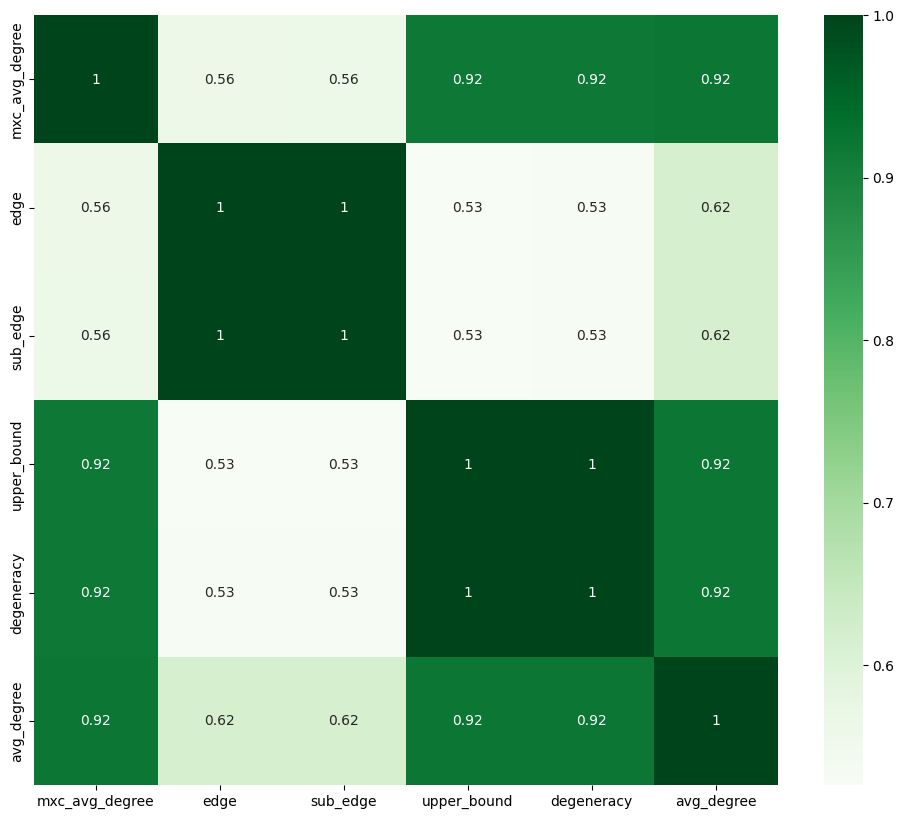

In [98]:
import seaborn as sns
corr_matrix = X_train_top.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='Greens')
plt.show()

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

model_randomForest = MultiOutputClassifier(
    RandomForestClassifier(
        n_estimators=700,
        class_weight="balanced",
        n_jobs=-1,
        random_state=32
    )
)

model_randomForest.fit(X_train_top, y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                       n_estimators=700,
                                                       n_jobs=-1,
                                                       random_state=32))

In [100]:
model_predict = model_randomForest.predict(X_test_top)

In [101]:
model_predict = np.array(model_predict)

In [102]:
model_predict

array([[0, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [0, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 1, 1],
       [1, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 1],
       [0, 1, 1, 1],
       [1, 1, 0, 0],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [0, 1, 0, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 1, 1],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1],
       [1, 1,

In [103]:
correct = 0
total = len(y_test)

for i in range(total):
  for j in range(4):
    if y_test.iloc[i,j] == 1 and model_predict[i,j] == 1:
      correct += 1
      break;

print(correct/total)

0.9333333333333333


In [104]:
correct

56